In [ ]:
import warnings
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
import itertools
import time

import jax
import jax.numpy as jnp
from jax import random
from jax.experimental import sparse as jsparse
from jax.lax import scan, dot_general
import jax.nn as jnn

import optax
import numpy as np

from data import dataset_LLT
from conj_grad import ConjGrad, apply_LLT
from loss import LLT_loss
from model import MessagePassing, FullyConnectedNet, PrecNet
from train import train, compute_loss_LLT

In [3]:
grid = 32
N_samples = 32

In [4]:
A_train, b_train, u_exact_train, bi_edges_train, nodes_train, edges_train, receivers_train, senders_train = dataset_LLT(grid, N_samples, seed=42)
A_test, b_test, u_exact_test, bi_edges_test, nodes_test, edges_test, receivers_test, senders_test = dataset_LLT(grid, 4, seed=43)

2024-03-04 17:33:55.871482: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)

In [6]:
X_train = (nodes_train, edges_train, receivers_train, senders_train, bi_edges_train, u_exact_train, b_train)
X_test = (nodes_test, edges_test, receivers_test, senders_test, bi_edges_test, u_exact_test, b_test)
data = (X_train, X_test, jnp.array([1]), jnp.array([1]))

train_config = {'optimizer': optax.adamw, 'lr': 1e-3,
                'optim_params': {'weight_decay': 1e-4}, 
                'epoch_num': 100}
model, losses = train(model, data, train_config, compute_loss_LLT)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, train loss: 451859.71875, test loss:212144.578125
Epoch: 1, train loss: 369349.9375, test loss:178501.21875
Epoch: 2, train loss: 310762.84375, test loss:151652.625
Epoch: 3, train loss: 264140.125, test loss:129914.515625
Epoch: 4, train loss: 226308.21875, test loss:110428.25
Epoch: 5, train loss: 192369.328125, test loss:92875.390625
Epoch: 6, train loss: 161823.203125, test loss:77105.328125
Epoch: 7, train loss: 134368.375, test loss:63085.76171875
Epoch: 8, train loss: 109952.2890625, test loss:50917.55859375
Epoch: 9, train loss: 88755.2421875, test loss:40310.21875
Epoch: 10, train loss: 70275.953125, test loss:31198.216796875
Epoch: 11, train loss: 54400.265625, test loss:23504.44921875
Epoch: 12, train loss: 40993.90625, test loss:17130.529296875
Epoch: 13, train loss: 29886.005859375, test loss:12259.498046875
Epoch: 14, train loss: 21403.640625, test loss:9263.623046875
Epoch: 15, train loss: 16179.890625, test loss:6787.37353515625
Epoch: 16, train loss: 11860.48

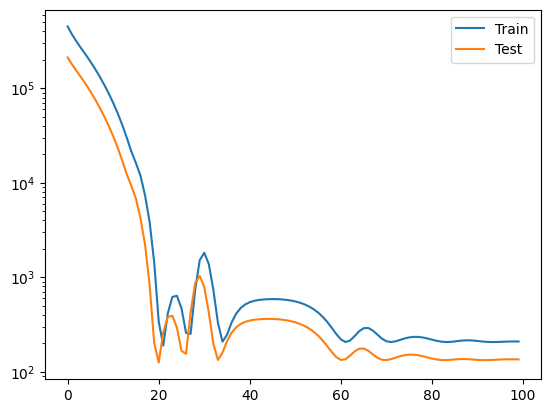

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(losses.shape[0]), losses[:, 0], label='Train')
plt.plot(range(losses.shape[0]), losses[:, 1], label='Test')
plt.legend();
plt.yscale('log')